In [50]:
#leer datos
import numpy as np
import pandas as pd
my_data = pd.read_csv('intents_raw.csv', sep=',', header=None)
my_data
text = np.array(my_data[1]) #texto asociado a la intencion
labels = np.array(my_data[0]) #intencion

In [51]:
#limpiado datos signos de puntuacion, todo a miniscula y quitar las tildes
import string
import re
def cleanText(textToClean):
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in textToClean]
    return stripped

def toLowerCase(textToClean):
    textToClean = [word.lower() for word in textToClean]
    return textToClean
    
def remove_accents_wrapper(textToClean):
    textToClean = re.sub(u"[àáâãäå]", 'a', textToClean)
    textToClean = re.sub(u"[èéêë]", 'e', textToClean)
    textToClean = re.sub(u"[ìíîï]", 'i', textToClean)
    textToClean = re.sub(u"[òóôõö]", 'o', textToClean)
    textToClean = re.sub(u"[ùúûü]", 'u', textToClean)
    textToClean = re.sub(u"[ñ]", 'n', textToClean)
    return textToClean

def remove_accents(textToClean):
    textToClean = [remove_accents_wrapper(word) for word in textToClean]
    return textToClean

text = remove_accents(toLowerCase(cleanText(text)))

In [52]:
#test de prueba del 30 porciento
test_size = 0.3
from sklearn.model_selection import train_test_split
train_txt,test_txt,train_label,test_labels = train_test_split(text,labels,test_size = test_size)

In [53]:
#tokenizar y aplicar padding
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
max_num_words = 4000
percentil = 100 #100 - percentil seria el porcentaje de las colas en una disbrucion normal a no ser tomado en cuenta, introducimos variabilidad al test de entrenamiento
classes = np.unique(labels)

#tokenizamos
tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(train_txt)
word_index = tokenizer.word_index #obtenemos el diccionario

# añadimos padding
ls=[]
for c in train_txt:
    ls.append(len(c.split()))
maxLen=int(np.percentile(ls, percentil))
train_sequences = tokenizer.texts_to_sequences(train_txt)
train_sequences = pad_sequences(train_sequences, maxlen=maxLen,padding='post')
test_sequences = tokenizer.texts_to_sequences(test_txt)
test_sequences = pad_sequences(test_sequences, maxlen=maxLen, padding='post')

In [54]:
#aplicamos One-Hot Encoding
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(classes)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoder.fit(integer_encoded)
train_label_encoded = label_encoder.transform(train_label)
train_label_encoded = train_label_encoded.reshape(len(train_label_encoded), 1)
train_label = onehot_encoder.transform(train_label_encoded)
test_labels_encoded = label_encoder.transform(test_labels)
test_labels_encoded = test_labels_encoded.reshape(len(test_labels_encoded), 1)
test_labels = onehot_encoder.transform(test_labels_encoded)


In [58]:
#modelo de aprendizaje
num_words = min(max_num_words, len(word_index))+1
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional,Embedding
model = Sequential()
model.add(Embedding(num_words, 100, trainable=False,input_length=train_sequences.shape[1]))
model.add(Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.1, dropout=0.1), 'concat'))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=False, recurrent_dropout=0.1, dropout=0.1))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(classes.shape[0], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [59]:
history = model.fit(train_sequences, train_label, epochs = 20,
          batch_size = 64, shuffle=True,
          validation_data=[test_sequences, test_labels])

Train on 67 samples, validate on 29 samples
Epoch 1/20
67/67 [==============================] - 4s 53ms/sample - loss: 2.1974 - acc: 0.0597 - val_loss: 2.1918 - val_acc: 0.2759
Epoch 2/20
67/67 [==============================] - 0s 6ms/sample - loss: 2.1898 - acc: 0.1642 - val_loss: 2.1830 - val_acc: 0.0690
Epoch 3/20
67/67 [==============================] - 0s 6ms/sample - loss: 2.1803 - acc: 0.1493 - val_loss: 2.1709 - val_acc: 0.0690
Epoch 4/20
67/67 [==============================] - 0s 6ms/sample - loss: 2.1630 - acc: 0.1493 - val_loss: 2.1557 - val_acc: 0.0690
Epoch 5/20
67/67 [==============================] - 0s 6ms/sample - loss: 2.1718 - acc: 0.0597 - val_loss: 2.1430 - val_acc: 0.0690
Epoch 6/20
67/67 [==============================] - 0s 6ms/sample - loss: 2.1638 - acc: 0.1045 - val_loss: 2.1370 - val_acc: 0.0690
Epoch 7/20
67/67 [==============================] - 0s 6ms/sample - loss: 2.1734 - acc: 0.1194 - val_loss: 2.1318 - val_acc: 0.2414
Epoch 8/20
67/67 [=============

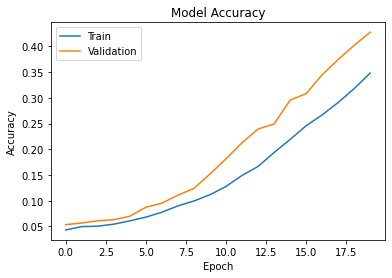

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

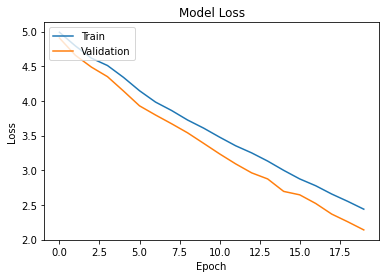

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()